# Reinforcement Learning 2025 - Policy Evaluation

**Authors:** Amit Ezer, Gal Yaacov Noy.

In [1]:
!pip install minigrid gymnasium matplotlib

In [9]:
import os
import numpy as np
import torch
from gymnasium.wrappers import RecordVideo
import minigrid
import matplotlib.pyplot as plt
from IPython.display import Video, display
from shared_utils import device, set_seeds, preprocess, create_env, QNetwork, ActorCritic

set_seeds(42)

print(f"Using device: {device}")

Using device: cuda


In [10]:
def run_episode(env, model, model_type="dqn", max_steps=200):
    """Run a single episode using the provided neural network model."""
    obs, _ = env.reset()
    state = preprocess(obs).to(device)
    total_reward, step = 0, 0
    terminated = truncated = False

    with torch.no_grad():
        while not (terminated or truncated) and step < max_steps:
            # Select action based on model type
            if model_type == "dqn":
                # For DQN: greedily select action with highest Q-value
                q_values = model(state.unsqueeze(0))
                action = q_values.argmax(dim=1).item()
            elif model_type == "ppo":
                # For PPO: sample from policy or use greedy action
                logits, _ = model(state.unsqueeze(0))
                action = torch.argmax(logits, dim=1).item()  # Greedy action for evaluation
            else:
                raise ValueError(f"Unknown model type: {model_type}")

            next_obs, reward, terminated, truncated, _ = env.step(action)
            state = preprocess(next_obs).to(device)
            total_reward += reward
            step += 1
            obs = next_obs

    success = reward > 0 and terminated
    return total_reward, step, success

In [11]:
def load_model(model_path, model_type, num_actions, input_size=56):
    """Load a PyTorch model from a .pth file."""
    if model_type == "dqn":
        model = QNetwork(num_actions, input_size=input_size).to(device)
    elif model_type == "ppo":
        model = ActorCritic(num_actions, input_size=input_size).to(device)
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def evaluate_policy(env, model, model_type="dqn", num_episodes=100, max_steps=200):
    """Evaluate a neural network policy over multiple episodes."""
    rewards, steps, successes = [], [], []

    for episode in range(num_episodes):
        total_reward, step, success = run_episode(env, model, model_type, max_steps)
        rewards.append(total_reward)
        steps.append(step)
        successes.append(success)

        if episode % 20 == 0:
            print(f"  Episode {episode}: Reward={total_reward:.2f}, Steps={step}, Success={success}")

    return {
        "rewards": rewards,
        "steps": steps,
        "successes": successes,
    }

def record_final_video(model, model_type, env_size="6x6", model_name="dqn"):
    """Record a video of a single greedy policy episode."""
    env_name = f"MiniGrid-Dynamic-Obstacles-{env_size}-v0"
    filename = f"{env_size}-{model_name}-final"
    video_dir = "videos"

    os.makedirs(video_dir, exist_ok=True)

    env_wrapped = RecordVideo(
        create_env(env_name, render_mode="rgb_array"),
        video_folder=video_dir,
        name_prefix=filename,
        episode_trigger=lambda _: True
    )

    run_episode(env_wrapped, model, model_type, max_steps=100)
    env_wrapped.close()

    return os.path.join(video_dir, f"{filename}-episode-0.mp4")

In [12]:
def run_evaluation(config_name, env_name, models_dir="models"):
    """Run evaluation for a configuration and return results with videos."""
    print(f"\n{'='*50}")
    print(f"EVALUATING: {config_name}")
    print(f"{'='*50}")

    env = create_env(env_name)
    num_actions = env.action_space.n
    
    # Get environment size for model directory
    env_suffix = env_name.split('-')[-2].replace('v0', '').strip()
    model_folder = os.path.join(models_dir, env_suffix)
    env_size = "6x6" if "6x6" in env_name else ("5x5" if "5x5" in env_name else "16x16")
    
    results = {}

    # Load and evaluate Double DQN
    dqn_path = os.path.join(model_folder, "double_dqn_model.pth")
    if os.path.exists(dqn_path):
        print("Loading Double DQN model...")
        dqn_model = load_model(dqn_path, "dqn", num_actions)
        print("Evaluating Double DQN...")
        results["Double DQN"] = evaluate_policy(env, dqn_model, "dqn")
        results["Double DQN"]["video"] = record_final_video(dqn_model, "dqn", env_size, "double_dqn")
    else:
        print(f"Double DQN model not found at: {dqn_path}")

    # Load and evaluate PPO
    ppo_path = os.path.join(model_folder, "ppo_model.pth")
    if os.path.exists(ppo_path):
        print("Loading PPO model...")
        ppo_model = load_model(ppo_path, "ppo", num_actions)
        print("Evaluating PPO...")
        results["PPO"] = evaluate_policy(env, ppo_model, "ppo")
        results["PPO"]["video"] = record_final_video(ppo_model, "ppo", env_size, "ppo")
    else:
        print(f"PPO model not found at: {ppo_path}")

    env.close()
    return results

In [14]:
# Run evaluations for trained neural network models
# Based on the environments used in training notebook
configs = [
    '5x5',
    '6x6',
    # '16x16'
]

all_results = {}
for config_name in configs:
    all_results[config_name] = run_evaluation(config_name, f'MiniGrid-Dynamic-Obstacles-{config_name}-v0')

# Add summary metrics
for config_name, results in all_results.items():
    for alg_name, metrics in results.items():
        if metrics:  # Only process if results exist
            metrics["success_rate"] = np.mean(metrics["successes"])
            metrics["avg_reward"] = np.mean(metrics["rewards"])
            metrics["avg_steps"] = np.mean(metrics["steps"])


EVALUATING: 5x5
Loading Double DQN model...
Evaluating Double DQN...
  Episode 0: Reward=-1.00, Steps=2, Success=False
  Episode 20: Reward=-1.00, Steps=2, Success=False
  Episode 40: Reward=-1.00, Steps=3, Success=False
  Episode 60: Reward=-1.00, Steps=3, Success=False
  Episode 80: Reward=-1.00, Steps=1, Success=False


/home/galnoy/git-projects/MSC-Reinforcement-Learning/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /home/galnoy/git-projects/MSC-Reinforcement-Learning/final/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Loading PPO model...
Evaluating PPO...
  Episode 0: Reward=0.00, Steps=100, Success=False
  Episode 20: Reward=0.00, Steps=100, Success=False
  Episode 40: Reward=0.00, Steps=100, Success=False
  Episode 60: Reward=0.00, Steps=100, Success=False
  Episode 80: Reward=0.00, Steps=100, Success=False


/home/galnoy/git-projects/MSC-Reinforcement-Learning/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /home/galnoy/git-projects/MSC-Reinforcement-Learning/final/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(



EVALUATING: 6x6
Loading Double DQN model...
Evaluating Double DQN...
  Episode 0: Reward=-1.00, Steps=1, Success=False
  Episode 20: Reward=-1.00, Steps=3, Success=False
  Episode 40: Reward=-1.00, Steps=4, Success=False
  Episode 60: Reward=-1.00, Steps=4, Success=False
  Episode 80: Reward=-1.00, Steps=4, Success=False
Loading PPO model...
Evaluating PPO...
  Episode 0: Reward=0.00, Steps=144, Success=False
  Episode 20: Reward=0.00, Steps=144, Success=False
  Episode 40: Reward=0.00, Steps=144, Success=False
  Episode 60: Reward=0.00, Steps=144, Success=False
  Episode 80: Reward=0.00, Steps=144, Success=False


In [15]:
# Results summary and video display
print(f"\n{'='*80}")
print("EVALUATION RESULTS SUMMARY")
print(f"{'='*80}")
print(f"{'Configuration':<15} {'Algorithm':<18} {'Success Rate':<12} {'Avg Reward':<12} {'Avg Steps':<10}")
print("-" * 70)

for config_name, results in all_results.items():
    for alg_name, metrics in results.items():
        success_rate = metrics["success_rate"]
        print(f"{config_name:<15} {alg_name:<18} {success_rate:<12.3f} {metrics['avg_reward']:<12.3f} {metrics['avg_steps']:<10.1f}")

# Display videos
print(f"\n{'='*50}")
print("PERFORMANCE VIDEOS")
print(f"{'='*50}")

for config_name, results in all_results.items():
    print(f"\n{config_name} Results:")
    for alg_name, metrics in results.items():
        print(f"\n{alg_name} - Success Rate: {metrics['success_rate']:.3f}")
        display(Video(metrics["video"], width=400, height=300, embed=True))


EVALUATION RESULTS SUMMARY
Configuration   Algorithm          Success Rate Avg Reward   Avg Steps 
----------------------------------------------------------------------
5x5             Double DQN         0.000        -1.000       2.0       
5x5             PPO                0.000        0.000        100.0     
6x6             Double DQN         0.000        -1.000       2.9       
6x6             PPO                0.000        0.000        144.0     

PERFORMANCE VIDEOS

5x5 Results:

Double DQN - Success Rate: 0.000



PPO - Success Rate: 0.000



6x6 Results:

Double DQN - Success Rate: 0.000



PPO - Success Rate: 0.000


In [16]:
def plot_eval_comparison(all_results, env_name):
    """Plot comparison between Double DQN and PPO for a configuration."""
    if env_name not in all_results:
        print(f"No results found for {env_name}")
        return
    
    results = all_results[env_name]
    
    # Check if both algorithms have results
    if "Double DQN" not in results or "PPO" not in results:
        print(f"Missing algorithm results for {env_name}")
        available_algs = list(results.keys())
        print(f"Available algorithms: {available_algs}")
        return
    
    dqn_results = results["Double DQN"]
    ppo_results = results["PPO"]

    print(f"\n{env_name} Results:")
    print(f"Double DQN – Success Rate: {np.mean(dqn_results['successes']):.3f}, "
          f"Avg Reward: {np.mean(dqn_results['rewards']):.3f}, "
          f"Avg Steps: {np.mean(dqn_results['steps']):.1f}")

    print(f"PPO – Success Rate: {np.mean(ppo_results['successes']):.3f}, "
          f"Avg Reward: {np.mean(ppo_results['rewards']):.3f}, "
          f"Avg Steps: {np.mean(ppo_results['steps']):.1f}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{env_name} - Double DQN vs PPO", fontsize=16)

    # Histogram of rewards
    axs[0].hist(dqn_results["rewards"], bins=20, alpha=0.6, label="Double DQN", color='blue')
    axs[0].hist(ppo_results["rewards"], bins=20, alpha=0.6, label="PPO", color='orange')
    axs[0].set_title("Total Rewards")
    axs[0].set_xlabel("Reward")
    axs[0].set_ylabel("Frequency")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Histogram of steps
    axs[1].hist(dqn_results["steps"], bins=20, alpha=0.6, label="Double DQN", color='blue')
    axs[1].hist(ppo_results["steps"], bins=20, alpha=0.6, label="PPO", color='orange')
    axs[1].set_title("Episode Lengths")
    axs[1].set_xlabel("Steps")
    axs[1].set_ylabel("Frequency")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    # Success rate over episodes
    dqn_sr = np.cumsum(dqn_results["successes"]) / np.arange(1, len(dqn_results["successes"]) + 1)
    ppo_sr = np.cumsum(ppo_results["successes"]) / np.arange(1, len(ppo_results["successes"]) + 1)

    axs[2].plot(dqn_sr, label="Double DQN", linewidth=2, color='blue')
    axs[2].plot(ppo_sr, label="PPO", linewidth=2, color='orange')
    axs[2].set_title("Cumulative Success Rate")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Success Rate")
    axs[2].legend()
    axs[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


DETAILED PERFORMANCE ANALYSIS

5x5 Results:
Double DQN – Success Rate: 0.000, Avg Reward: -1.000, Avg Steps: 2.0
PPO – Success Rate: 0.000, Avg Reward: 0.000, Avg Steps: 100.0


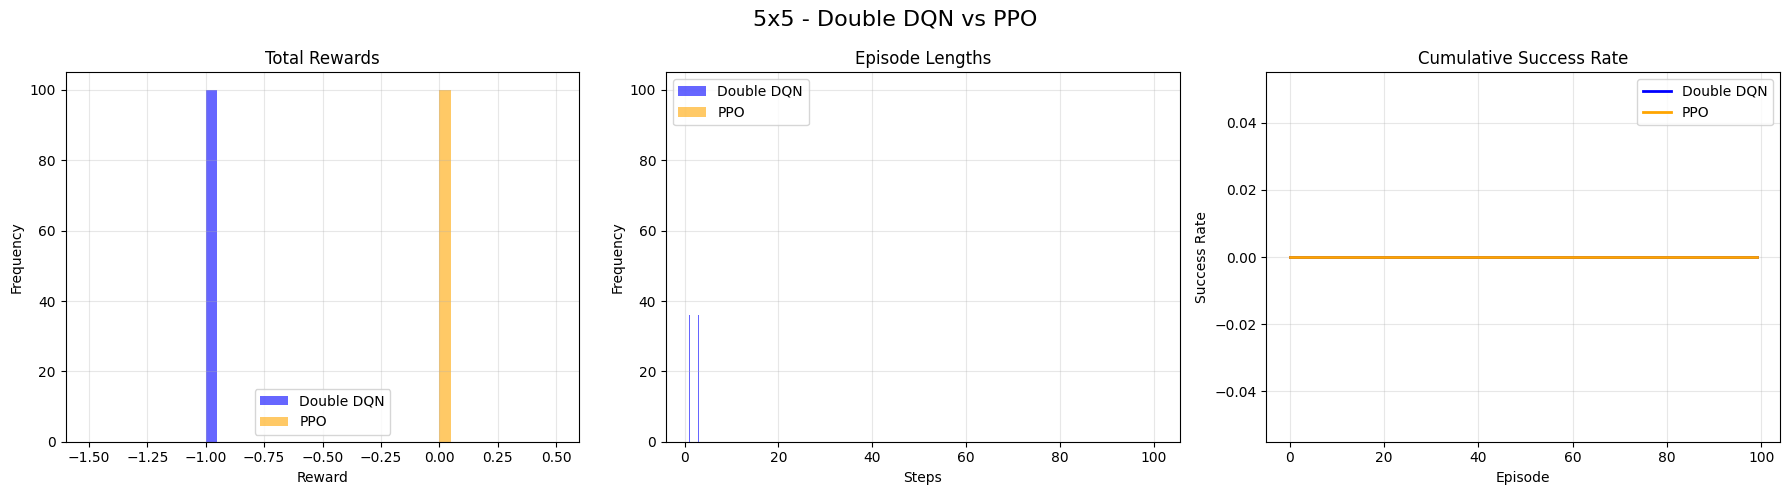


6x6 Results:
Double DQN – Success Rate: 0.000, Avg Reward: -1.000, Avg Steps: 2.9
PPO – Success Rate: 0.000, Avg Reward: 0.000, Avg Steps: 144.0


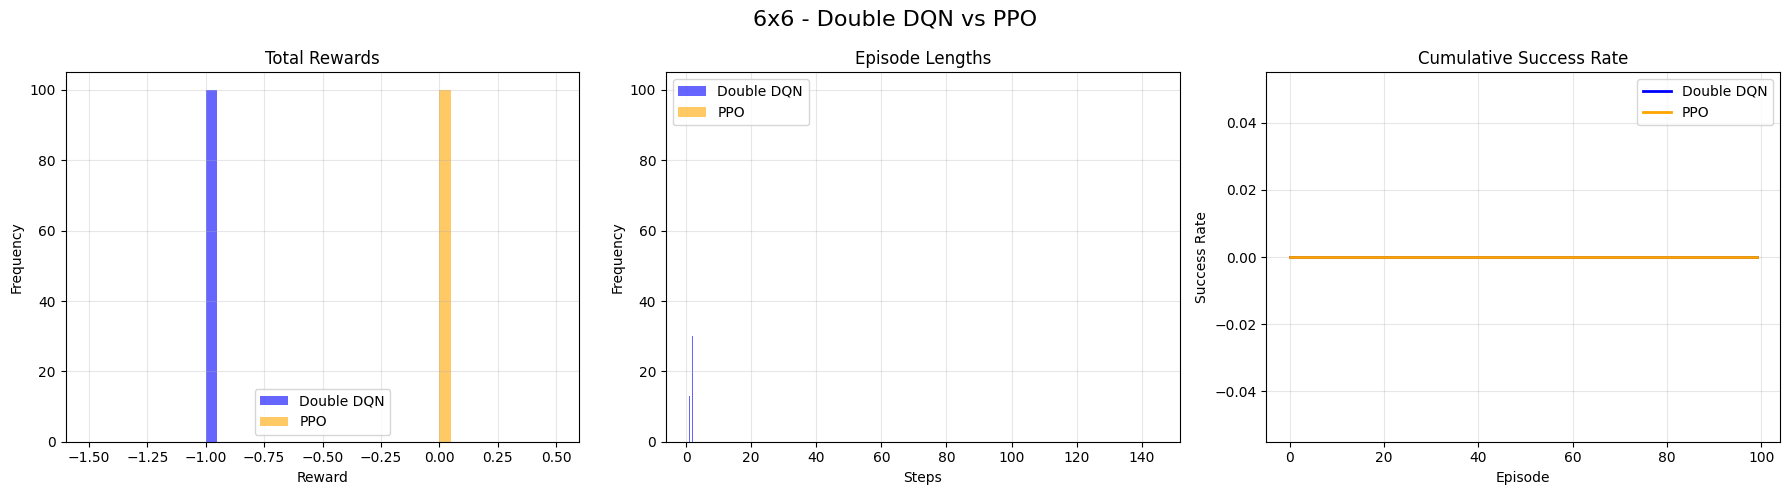


Evaluation complete!


In [17]:
print(f"\n{'='*60}")
print("DETAILED PERFORMANCE ANALYSIS")
print(f"{'='*60}")

# Plot comparisons for each environment that has results
for env_name in all_results.keys():
    if all_results[env_name]:  # Only plot if there are results
        plot_eval_comparison(all_results, env_name)

print("\nEvaluation complete!")